In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
from Simulations.odeSolver.doubleS import rxnNetwork, labels
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22, lgdFrameAlpha=0.0,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':lgdFrameAlpha}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

# occupancy and residence time v.s. protein concentrarion DNA+clusTarg

In [4]:
GenParm = lambda nDenseKPP: GenParameters(
    numTargets=2, KPN=[1], area3Dto1D=[100], KPS=lambda KPN: 1e3,
    NP0=2*np.logspace(-1, 1, 3+2*5), KPP=[0, 1e1, 1e6], kbPP_fixed=0.4,
)

parm_num = GenParm(0)

In [5]:
equi_num = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

2025-03-17 16:00:23.150437
Number of cores used:  34/36
Finished parallel processing.


In [6]:
pBound_num = np.zeros(parm_num.shape[0])
sOcc_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    equi = equi_num.iloc[iloc]
    pBound_num[iloc] = num.calc_BoundRatio_modelC(parm, equi)
    sOcc_num[iloc] = num.calc_occS_modelC(parm, equi)

In [7]:
def calc_resT_monomer_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+aS_to_aN) / koffN

resT_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    equi = equi_num.iloc[iloc]
    resT_num[iloc] = num.calc_resT_modelC(parm, equi)
resT_num_m = calc_resT_monomer_2state(parm_num)

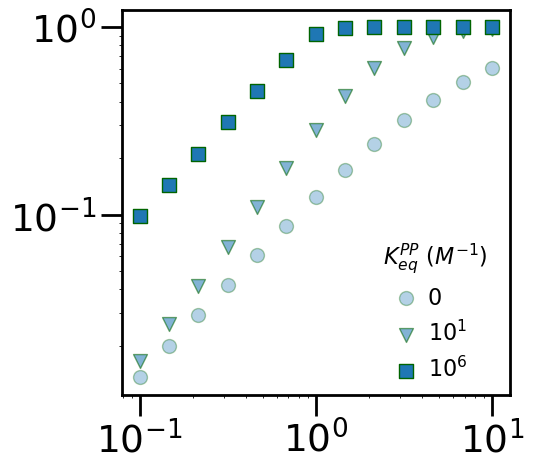

In [8]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.65,0.01], lgdFontSize=16, lgdHandleL=0.3, 
    lgdTitle='$K_{eq}^{PP}$ $(M^{-1})$', lgdTtlFontSize=16,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
labels = ['0', '$10^1$', '$10^6$']
gam_color = 'tab:blue'
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kppList = np.unique(parm_num['KPP'])
for i, kpp in enumerate(kppList):
    selected_num = ((parm_num['KPP']==kpp))
    # numerical solution (true)
    ax.scatter(
#         (parm_num['KPP']*parm_num['CP0'])[selected_num],
#         (sOcc_num/min(cp0/parm_num['CS0'].unique()[0],1))[selected_num],
        (parm_num['CP0']/parm_num['CS0'])[selected_num],
        (sOcc_num)[selected_num],
        zorder=3, s=100, color = gam_color, edgecolor='darkgreen', 
        alpha=alphas[i], marker=markers[i],
        label=labels[i],
    )

ax.loglog()
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.show()

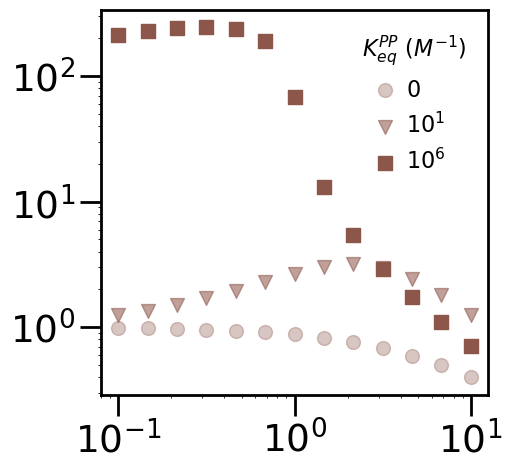

In [9]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.65,0.55], lgdFontSize=16, lgdHandleL=0.3, 
    lgdTitle='$K_{eq}^{PP}$ $(M^{-1})$', lgdTtlFontSize=16,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
kbP_color = 'tab:brown'
labels = ['0', '$10^1$', '$10^6$']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kppList = np.unique(parm_num['KPP'])
for i, kpp in enumerate(kppList):
    selected_num = ((parm_num['KPP']==kpp))
    # numerical solution (true)
    ax.scatter(
        (parm_num['CP0']/parm_num['CS0'])[selected_num],
        (resT_num/resT_num_m)[selected_num],
        label=labels[i], s=100,
        marker=markers[i], color=kbP_color, alpha=alphas[i],
    )

ax.loglog()
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.show()